## 2.4 Combination Matrix over directed network

This section we will discuss the combination matrix over the directed network topology. Directed network is more flexible than undirected network. It allows the scenario in which edge $(i,j)$ exists but $(j,i)$ does not. In fact, undirected network can be regarded as a special form of the directed network.

For a general directed network, it may not be possible to construct a doubly stochastic matrix (i.e., the matrix with row sum and column sum being 1, see Assumption 1 in Sec. 2.3) \[needs a double check\]. In this section, we will focus on the exponential-two graph, a special directed network topology that is widely used in high-performance computing and deep neural network training, and discuss its combination matrix.

### 2.4.1 Illustration of the exponential-two graph

Exponential-two graph is an important network topology that we will utilize frequently in following sections. In the exponential-two graph, each agent will communicate with the neighbors that are $2^0, 2^1, \cdots, 2^T$ hops away. Next, we will draw the exponential-two graph with BlueFog.

We first need to import necessary modules.

In [2]:
import numpy as np
import bluefog.torch as bf
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
from bluefog.common import topology_util
import matplotlib.pyplot as plt
%matplotlib inline

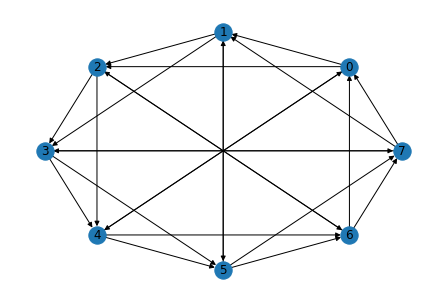

In [3]:
G = topology_util.ExponentialTwoGraph(8)
labels={0:7,1:0,2:1,3:2,4:3, 5:4, 6:5, 7:6}
nx.draw_circular(G, labels=labels)

The above network is directed in which each agent sends information to neighbors that are $2^0$, $2^1$ and $2^2$ hops away. For example, agent $0$ sends information to $1$, $2$ and $4$ while agent $1$ sends information to $2$, $3$, and $5$.

### 2.4.2 Combination matrix over the exponential-two graph

In the exponential-two graph, each node has the same incoming degree and outgoing degree. With this important property, we can easily construct a doubly stochastic combination matrix with averaging rule.

> **Averaging rule.** Providing an exponential-two topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + d},& \mbox{if $j \in \mathcal{N}_{\rm in}(i)$ or if $i = j$} , \\
			0,& \mbox{otherwise}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d = |\mathcal{N}_{\rm in}(i)|$ (the number of incoming neighbors of agent $i$). It is easy to verify such $W$ is always doubly-stochastic because incoming degree $d$ of each node is the same.

BlueFog generates the combination matrix of the exponential-two graph with the above averaging rule. To illustrate it, we next examine the combination matrix provided by BlueFog.

**Step I: Initialize BlueFog**

In [5]:
import ipyparallel as ipp

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [6]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 1 among 8 processes
[stdout:1] Hello, I am 3 among 8 processes
[stdout:2] Hello, I am 2 among 8 processes
[stdout:3] Hello, I am 5 among 8 processes
[stdout:4] Hello, I am 4 among 8 processes
[stdout:5] Hello, I am 6 among 8 processes
[stdout:6] Hello, I am 0 among 8 processes
[stdout:7] Hello, I am 7 among 8 processes


In [7]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

In [8]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

**Step II: Examine the combination matrix of the exponential-two graph**

We now fetch the combination matrix $W$ of exponential-two graph provided by BlueFog. To this end, we will pull the weights of each agent into the Jupyter engine and then construct the combination matrix. The method to pull information from agent is 

```dview.pull(information_to_pull, targets=agent_idx)```

It should be noted that ```agent_idx``` is not the rank of each agent. Instead, it is essentially the order that the engine collects information from each agent. We need to establish a mapping between rank and agent_idx.

In [11]:
network_size = dview.pull('bf.size()', block=True, targets=0)
agentID_to_rank = {}
for idx in range(network_size):
    agentID_to_rank[idx] = dview.pull('bf.rank()', block=True, targets=idx)
    
for k,v in agentID_to_rank.items():
    print('id:{}, rank:{}'.format(k, v))

id:0, rank:1
id:1, rank:3
id:2, rank:2
id:3, rank:5
id:4, rank:4
id:5, rank:6
id:6, rank:0
id:7, rank:7


We are ready to fetch the combination matrix $W$ of exponential-two graph provided by BlueFog.

In [12]:
%%px
G = topology_util.ExponentialTwoGraph(8)
self_weight, neighbor_weights = topology_util.GetRecvWeights(G, bf.rank())

In [13]:
network_size = dview.pull('bf.size()', block=True, targets=0)
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.25 0.   0.   0.   0.25 0.   0.25 0.25]
 [0.25 0.25 0.   0.   0.   0.25 0.   0.25]
 [0.25 0.25 0.25 0.   0.   0.   0.25 0.  ]
 [0.   0.25 0.25 0.25 0.   0.   0.   0.25]
 [0.25 0.   0.25 0.25 0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.25 0.25 0.25 0.   0.  ]
 [0.   0.   0.25 0.   0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.25 0.25]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


It can be easily verified that the above combination matrix for the $8$-agent exponential-two graph is achieved by the avreaging rule with the incoming degree $d=4$.